In [38]:
import numpy as np
import pandas as pd
from pandas.io import gbq

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from pitched_recommend import Recommender

sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.1f' % x)
%matplotlib inline

### Action plan

#### Make the lifelong streams table and determine with Robin what to include in the model (head-body-tail by genre)

#### Get the universe of playlists that are:
* Spotify and user owned
* Have number of followers in a given range (take the body)
* Remove playlists of owners who have too many playlists (excluding Spotify)
* Remove playlists with too small popularity and too high popularity
* Add all spotify browse categories playlists if not already tere
* Add playlists containing songs we target if not already there to make sure we cover all desired ISRC universe

In [ ]:
### Gather all the streams for all UMG rep on Spotify we see

sql_lifelong_streams = """
SELECT
MIN(stream_date) as first_stream_date,
MAX(stream_date) as last_stream_date,
isrc,
partner_track_uri,
COUNT(stream_datetime) as lifelong_streams
FROM
  `umg-partner.spotify.streams`
GROUP BY
isrc,
partner_track_uri
"""

sql_lifelong_streams_meta = """
SELECT
MIN(first_stream_date) as first_stream_date,
MAX(last_stream_date) as last_stream_date,
MAX(days_streams) as days_streams,
s.isrc as isrc,
MAX(track_name) as track,
MAX(artist_name) as artist,
MAX(e.original_release_date) as original_release_date,
MAX(e.major_label) as epf_label,
MAX(e.label_studio) as epf_studio,
MAX(m.label) as spotify_label,
MAX(e.genre_name) as genre_name,
MAX(e.parent_genre_name) as parent_genre_name,
MAX(s.partner_track_uri) as partner_track_uri,
MAX(lifelong_streams) as lifelong_streams
FROM
  `umg-comm-tech-dev.recommender_model.lifelong_streams` s
LEFT JOIN 
`umg-data-science.epf.song_label_view` e
USING (isrc)
LEFT JOIN `umg-partner.spotify.spotify_track_metadata` m
ON s.isrc=m.track_isrc
GROUP BY isrc
"""

In [2]:
sql_get_streams_data = """
SELECT
*
FROM
  `umg-comm-tech-dev.recommender_model.lifelong_streams_meta`
"""

data = gbq.read_gbq(sql_get_streams_data, project_id='umg-comm-tech-dev', dialect='standard')
data.head()

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams
0,2018-04-01,2019-02-03,308,INUM70504734,Bhola Bhandari - Shirdi Ke Sai Baba / Soundtra...,"Anup Jalota, Dilraj Kaur",2005-01-01,UMG,Universal Music India Pvt Ltd.,Universal Music India Pvt Ltd.,Bollywood,Indian,spotify:track:71Kmc7Ae2giipTTpxtFvvH,351
1,2018-04-01,2019-02-04,309,TWF670900102,"牧神搭上春色的火車,而",Sodagreen,2009-01-01,UMG,Universal Music Taiwan,Universal Music Taiwan,Mandopop,Pop,spotify:track:7r9HFmwFaIUfjvqalYq1zd,7823
2,2018-04-01,2019-01-30,304,PTUM10400094,Praia Da Saudade,Jorge Fernando,2016-07-18,UMG,Universal Music Portugal SA,Universal Music Portugal SA,Fado,World,spotify:track:6ifORSdq3xq8cJQwa47IKW,325
3,2018-04-01,2019-02-04,309,USNA10218729,Hidden World,"John Serrie, Gary Stroutsos",2005-12-20,UMG,"Narada Productions, Inc.","Narada Productions, Inc.",New Age,New Age,spotify:track:1WrZJzvKNXBcwz3c5T7Bvs,9217
4,2018-04-01,2019-02-04,309,DEUM70903289,Unbreakable,Stefanie Heinzmann,2009-01-01,UMG,Polydor/Island,SSDSDSSWEMUGABRTLAD,Pop/Rock,Pop,spotify:track:3JhHHF3tBAyRqUs3IsAQsA,11905


In [5]:
data.describe(include='all')

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams
count,1938958,1938958,1938958.0,1938958,1726142,1726142,1767687,1767687,1767666,1726142,1759905,1759608,1938958,1938958.0
unique,310,310,nan,1938958,1254585,165342,13026,4,14177,4299,279,47,1938620,nan
top,2018-04-01 00:00:00,2019-02-04 00:00:00,nan,USFI80400163,Intro,Party Tyme Karaoke,2013-01-01,UMG,Decca Music Group Ltd.,Universal Music Group,Pop,Pop,spotify:track:72DGpAMsjW5WbAfcOu6TFv,nan
freq,1259750,1340190,nan,1,1125,18831,43672,1504892,46118,279470,345325,366725,2,nan
first,2018-04-01 00:00:00,2018-04-01 00:00:00,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
last,2019-02-04 00:00:00,2019-02-04 00:00:00,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
mean,NaN,NaN,275.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103000.8
std,NaN,NaN,76.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2378407.6
min,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
25%,NaN,NaN,298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0


In [3]:
data.parent_genre_name = data.parent_genre_name.fillna('Unknown')
data.epf_label = data.epf_label.fillna('Unknown')
data.epf_studio = data.epf_studio.fillna('Unknown')
data.spotify_label = data.spotify_label.fillna('Unknown')

In [4]:
data.days_streams = data.days_streams.fillna(0.5)
data.days_streams = data.days_streams.replace(0,0.5)

In [5]:
data['weekly_streams'] = data['lifelong_streams'].div(data['days_streams'].values,axis=0)

In [6]:
data.weekly_streams.describe()

count   1938958.0
mean        443.6
std       14612.4
min           0.0
25%           0.2
50%           2.0
75%          16.0
max     9194206.0
Name: weekly_streams, dtype: float64

In [44]:
data_umg = data[data.epf_label=='UMG']
data_umg.shape

(1504892, 15)

In [45]:
data_no_zeros = data_umg[data_umg.weekly_streams>0]

In [46]:
data_no_zeros.shape

(1479531, 15)

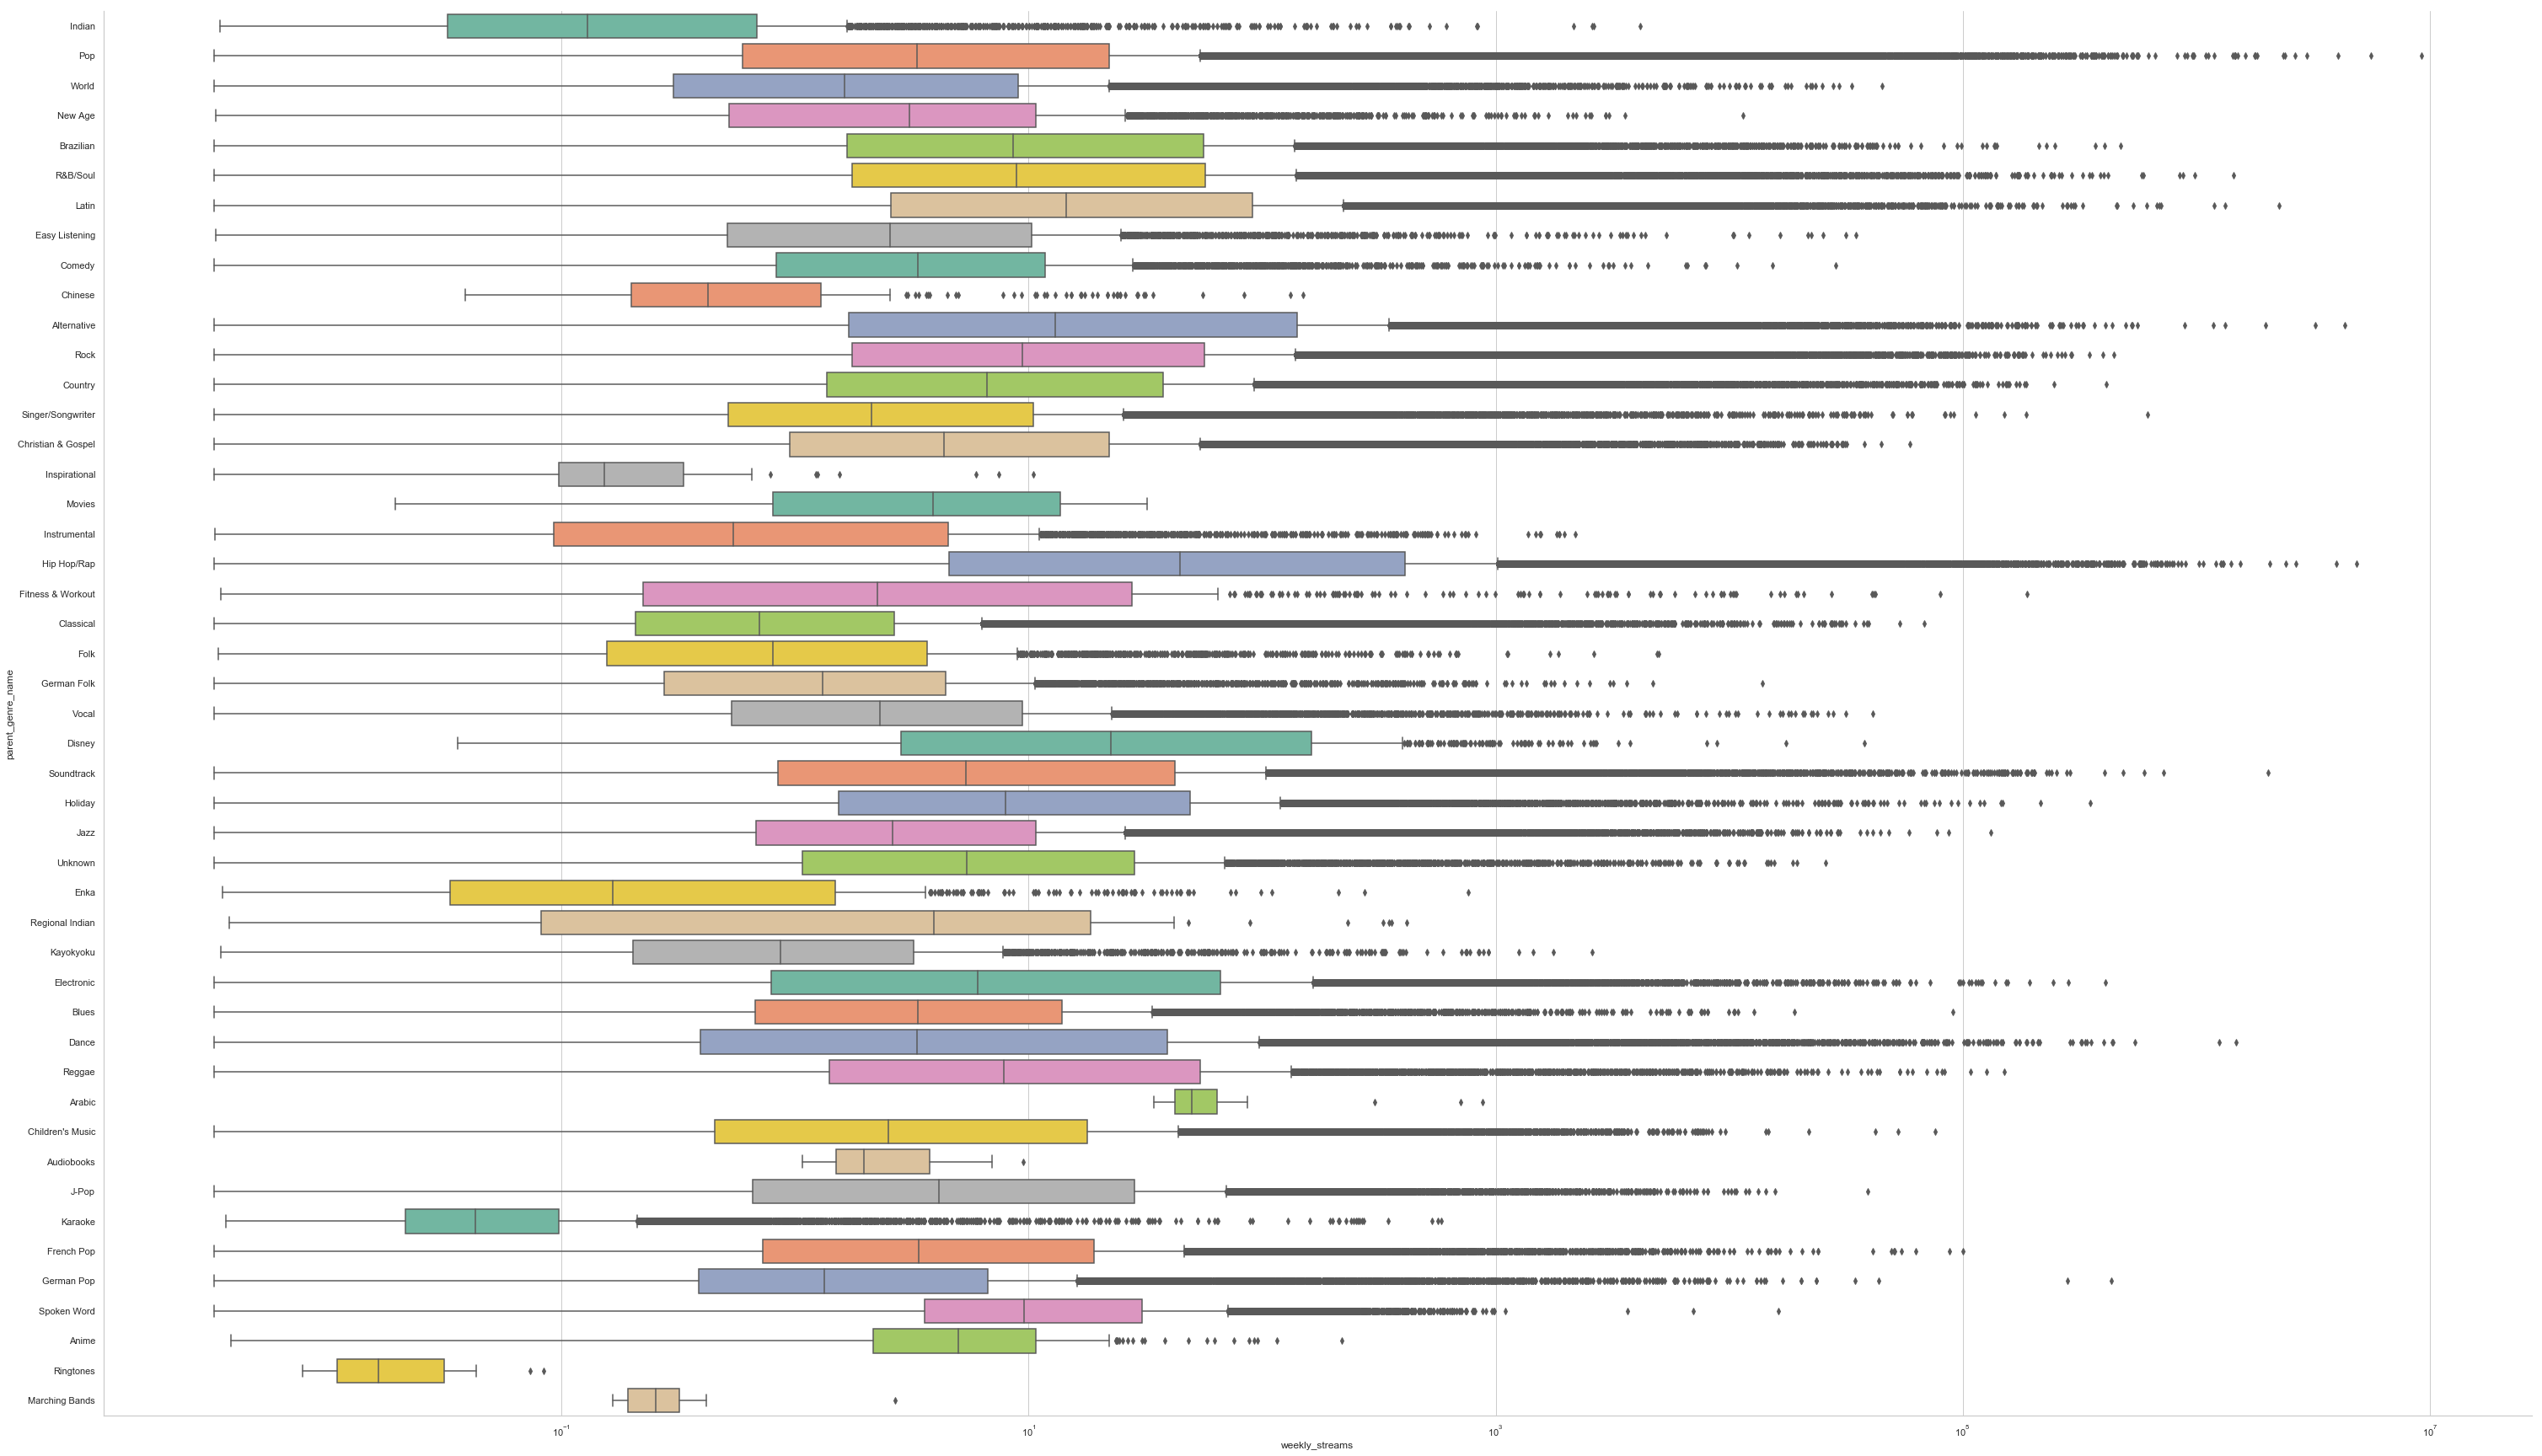

In [47]:
g = sns.catplot(data=data_no_zeros, orient="h", palette="Set2", x='weekly_streams', y='parent_genre_name',
           height=24, aspect=1.75, kind='box')
g.fig.get_axes()[0].set_xscale('log')
plt.show()

In [48]:
g.savefig("/Users/daria/Downloads/streams_by_genre.png")

In [49]:
by_parent_genre = data_no_zeros.groupby(by='parent_genre_name')

In [55]:
by_parent_genre.weekly_streams.describe(percentiles = [.1, .25, .5, .75, .9, .975])

,count,mean,std,min,10%,25%,50%,75%,90%,97.5%,max
parent_genre_name,,,,,,,,,,,
Alternative,44907.0,1361.8,30387.3,0.0,0.3,1.7,13.0,141.3,949.3,7287.6,4328537.2
Anime,143.0,12.8,25.8,0.0,0.4,2.2,5.0,10.8,25.0,90.0,219.6
Arabic,17.0,151.9,251.3,34.4,36.7,42.2,50.1,63.8,465.7,810.4,877.1
Audiobooks,15.0,3.3,2.5,1.1,1.3,1.5,2.0,3.8,6.9,8.6,9.5
Blues,12960.0,57.5,892.0,0.0,0.2,0.7,3.3,13.9,54.6,321.1,90984.8
Brazilian,24102.0,424.9,6085.3,0.0,0.5,1.7,8.6,56.3,340.5,2206.9,473321.3
Children's Music,27169.0,71.8,722.9,0.0,0.1,0.5,2.5,17.8,97.5,545.2,76402.4
Chinese,253.0,4.5,15.1,0.0,0.1,0.2,0.4,1.3,12.8,30.6,149.7
Christian & Gospel,37638.0,150.2,1137.9,0.0,0.2,0.9,4.3,22.2,128.0,1001.1,59172.1


In [56]:
genre_stats = by_parent_genre.weekly_streams.describe(percentiles = [.1, .25, .5, .75, .9, .975])

In [75]:
genre_stats.columns=['count','mean','std','min',
                                                        'perc_10','perc_25','perc_50','perc_75','perc_90',
                                                        'perc_975','max']
genre_stats.head()

,count,mean,std,min,perc_10,perc_25,perc_50,perc_75,perc_90,perc_975,max
parent_genre_name,,,,,,,,,,,
Alternative,44907.0,1361.8,30387.3,0.0,0.3,1.7,13.0,141.3,949.3,7287.6,4328537.2
Anime,143.0,12.8,25.8,0.0,0.4,2.2,5.0,10.8,25.0,90.0,219.6
Arabic,17.0,151.9,251.3,34.4,36.7,42.2,50.1,63.8,465.7,810.4,877.1
Audiobooks,15.0,3.3,2.5,1.1,1.3,1.5,2.0,3.8,6.9,8.6,9.5
Blues,12960.0,57.5,892.0,0.0,0.2,0.7,3.3,13.9,54.6,321.1,90984.8


In [76]:
genre_stats_export = genre_stats.reset_index()

In [77]:
genre_stats_export.head()

,parent_genre_name,count,mean,std,min,perc_10,perc_25,perc_50,perc_75,perc_90,perc_975,max
0,Alternative,44907.0,1361.8,30387.3,0.0,0.3,1.7,13.0,141.3,949.3,7287.6,4328537.2
1,Anime,143.0,12.8,25.8,0.0,0.4,2.2,5.0,10.8,25.0,90.0,219.6
2,Arabic,17.0,151.9,251.3,34.4,36.7,42.2,50.1,63.8,465.7,810.4,877.1
3,Audiobooks,15.0,3.3,2.5,1.1,1.3,1.5,2.0,3.8,6.9,8.6,9.5
4,Blues,12960.0,57.5,892.0,0.0,0.2,0.7,3.3,13.9,54.6,321.1,90984.8


In [87]:
gbq.to_gbq(genre_stats_export, destination_table='recommender_model.genre_stats', project_id='umg-comm-tech-dev',
          if_exists = 'replace')

1it [00:06,  6.38s/it]


In [52]:
data_no_zeros[(data_no_zeros.parent_genre_name=='Reggae')&(data_no_zeros.weekly_streams<1)]

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams,weekly_streams
451735,2018-04-01,2019-01-26,300.0,GBAJE7300102,In The Dark,Toots & The Maytals,2002-01-01,UMG,Hip-O,Sanctuary Records,Reggae,Reggae,spotify:track:6K6Nr6bXEFMJ8ieS1ws3Bi,89,0.3
451759,2018-04-01,2019-02-02,307.0,COUM71500099,Yo Quiero Respirar,Carmen Jiménez,2015-12-11,UMG,Universal Music Colombia S.A.S.,Universal Music Colombia S.A.S.,Reggae,Reggae,spotify:track:6Ka0CpsRFjFDRg3ne0P6pr,138,0.4
451776,2018-05-25,2019-02-03,254.0,PHUM71600193,Babylon Dem,Martin Buchanan,2016-01-01,UMG,Universal Music Philippines Inc.,Universal Music Philippines Inc.,Reggae,Reggae,spotify:track:1Spp5V6bldnPNYLXFhrNW8,46,0.2
451784,2018-04-03,2019-02-02,305.0,USUM70970194,Minimum Wages,Flourgon,2009-06-16,UMG,Island Records,Island Records,Reggae,Reggae,spotify:track:387QaksBNdcz8DQolHrwMA,32,0.1
451803,2018-04-01,2019-02-04,309.0,GBAJE6800238,School Days,The Maytals,2002-01-01,UMG,Hip-O,Sanctuary Records,Reggae,Reggae,spotify:track:4nMnShqAo61efAcPYb2rLB,173,0.6
451804,2018-04-02,2019-01-27,300.0,GBAJE0608501,The Truth,Lion,1999-01-01,UMG,Hip-O,Universal Music Enterprises,Reggae,Reggae,spotify:track:3zXRRstsLtaloyJCB218La,7,0.0
451817,2018-04-07,2019-01-19,287.0,FIUNP0700543,Lista - 2007 Digital Remaster,Liz & Lizards,2007-12-12,UMG,POKO,POKO,Reggae,Reggae,spotify:track:6DPHuXJ3IPnkCzh1rnB9sz,29,0.1
451821,2018-04-02,2019-02-03,307.0,USIR20400474,So Fine,George Faith,2004-01-01,UMG,Hip-O Select Retail (PG),Universal Music Central America,Reggae,Reggae,spotify:track:7szFgLE1dLVab7izV257Xo,300,1.0
451824,2018-04-07,2019-02-03,302.0,GBAJE0300111,Headline News - Live,"Floyd Lloyd, Ernest Ranglin",2008-02-11,UMG,Sanctuary Records Group Ltd.,Sanctuary Records Group Ltd.,Reggae,Reggae,spotify:track:63QQkqODR6Ce9TP1hTV3ea,87,0.3
451825,2018-04-01,2019-02-04,309.0,USUM70721463,Officer Jimmy Interlude - Main,Stephen Marley,2007-03-20,UMG,Universal Records/Tuff Gong Records,Universal/Island Def Jam,Reggae,Reggae,spotify:track:72KIoyGgP0CLJx0BgQQmeQ,10,0.0


In [80]:
data_no_zeros = data_no_zeros.reset_index(drop=True)

In [81]:
data_no_zeros['check'] = 0
for i in range(data_no_zeros.shape[0]):
    if data_no_zeros.weekly_streams[i] > genre_stats.loc[data_no_zeros.parent_genre_name[i]]['perc_10']:
        if data_no_zeros.weekly_streams[i] < genre_stats.loc[data_no_zeros.parent_genre_name[i]]['perc_975']:
            data_no_zeros.check[i] =1
            
data_no_zeros.check.describe()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


KeyboardInterrupt: 

In [82]:
data_no_zeros.head()

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams,weekly_streams,check
0,2018-04-01,2019-02-03,308.0,INUM70504734,Bhola Bhandari - Shirdi Ke Sai Baba / Soundtra...,"Anup Jalota, Dilraj Kaur",2005-01-01,UMG,Universal Music India Pvt Ltd.,Universal Music India Pvt Ltd.,Bollywood,Indian,spotify:track:71Kmc7Ae2giipTTpxtFvvH,351,1.1,1
1,2018-04-01,2019-02-04,309.0,TWF670900102,"牧神搭上春色的火車,而",Sodagreen,2009-01-01,UMG,Universal Music Taiwan,Universal Music Taiwan,Mandopop,Pop,spotify:track:7r9HFmwFaIUfjvqalYq1zd,7823,25.3,1
2,2018-04-01,2019-01-30,304.0,PTUM10400094,Praia Da Saudade,Jorge Fernando,2016-07-18,UMG,Universal Music Portugal SA,Universal Music Portugal SA,Fado,World,spotify:track:6ifORSdq3xq8cJQwa47IKW,325,1.1,1
3,2018-04-01,2019-02-04,309.0,USNA10218729,Hidden World,"John Serrie, Gary Stroutsos",2005-12-20,UMG,"Narada Productions, Inc.","Narada Productions, Inc.",New Age,New Age,spotify:track:1WrZJzvKNXBcwz3c5T7Bvs,9217,29.8,1
4,2018-04-01,2019-02-04,309.0,DEUM70903289,Unbreakable,Stefanie Heinzmann,2009-01-01,UMG,Polydor/Island,SSDSDSSWEMUGABRTLAD,Pop/Rock,Pop,spotify:track:3JhHHF3tBAyRqUs3IsAQsA,11905,38.5,1


In [84]:
data_no_zeros['check'] = 0
data_no_zeros['check'] = [1 if (x>genre_stats.loc[y]['perc_10'])&(x<genre_stats.loc[y]['perc_975']) else 0 for x,y in zip(data_no_zeros['weekly_streams'],data_no_zeros['parent_genre_name'])]

In [85]:
data_no_zeros.check.describe()

count   1479531.0
mean          0.9
std           0.3
min           0.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: check, dtype: float64

In [86]:
data_export = data_no_zeros[data_no_zeros.check==1]

In [88]:
gbq.to_gbq(data_export, destination_table='recommender_model.universe', project_id='umg-comm-tech-dev', 
           if_exists='replace')

1it [00:48, 48.97s/it]


In [89]:
isrc_universe = data_export.isrc.unique()
print(len(isrc_universe))

1294444


## Playlist gathering

In [90]:
playlists_all_sql = """
WITH
  tracks AS (
  SELECT
    playlist_uri,
    artist_uri,
    album_uri,
    track_position
  FROM
    `umg-partner.spotify.playlist_track_history`
  WHERE
    _PARTITIONTIME >= TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 367 DAY))
    AND _PARTITIONTIME < TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 2 DAY))),
  playlists AS (
  SELECT
    playlist_uri
  FROM
    `umg-partner.spotify.playlist_history`
  WHERE
    _PARTITIONTIME >= TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 367 DAY))
    AND _PARTITIONTIME < TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 2 DAY))
    AND follower_count>=10
  GROUP BY
    playlist_uri)
SELECT
  playlist_uri,
  COUNT(DISTINCT artist_uri) AS nartists,
  COUNT(DISTINCT album_uri) AS nalbums,
  MAX(track_position) AS maxpos
FROM
  tracks
WHERE
  playlist_uri IN (
  SELECT
    playlist_uri
  FROM
    playlists)
GROUP BY
  playlist_uri
HAVING
  nartists > 2
  AND nalbums > 2
  AND maxpos<=500
"""

In [91]:
playlists_tracks_sql = """
SELECT
  playlist_uri,
  isrc,
  COUNT(DISTINCT playlist_date) AS days_on_playlist
FROM
  `umg-partner.spotify.playlist_track_history`
WHERE
  _PARTITIONTIME >= TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 367 DAY))
  AND _PARTITIONTIME < TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 2 DAY))
  AND playlist_uri IN (
  SELECT
    playlist_uri
  FROM
    `umg-comm-tech-dev.recommender_model.all_playlists`
  GROUP BY
    playlist_uri)
GROUP BY
  playlist_uri,
  isrc
"""

In [2]:
get_playlist_data_sql = """
SELECT * FROM `umg-comm-tech-dev.recommender_model.all_playlists_isrcs`
"""

In [4]:
playlist_data = gbq.read_gbq(get_playlist_data_sql, project_id = 'umg-comm-tech-dev', dialect = 'standard')

KeyboardInterrupt: 

In [ ]:
len(playlist_data.isrc.unique())

In [25]:
get_distinct_isrc_sql = """
SELECT DISTINCT(isrc) FROM `umg-comm-tech-dev.recommender_model.all_playlists_isrcs`
"""

isrcs = gbq.read_gbq(get_distinct_isrc_sql, project_id = 'umg-comm-tech-dev', dialect = 'standard')

In [6]:
get_umg_isrc_sql = """
SELECT DISTINCT(isrc) FROM `umg-comm-tech-dev.recommender_model.universe`
"""

umg_isrcs = gbq.read_gbq(get_umg_isrc_sql, project_id='umg-comm-tech-dev', 
           dialect = 'standard')

In [26]:
print(len(umg_isrcs))
print(len(isrcs))

1294444
4224204


Amount of unique UMG isrcs in the new set of data:

In [31]:
intersect = list(set(umg_isrcs.isrc)&set(isrcs.isrc))

In [32]:
len(intersect)

372707

Amount of unique UMG isrcs in the model now:

In [23]:
with open('/Users/daria/development/umg/recommender/playlist_pitching/metadata_dict.pkl', 'rb') as f:
    meta_dict = pickle.load(f)
with open('/Users/daria/development/umg/recommender/playlist_pitching/model_20181112_lighter.pkl', 'rb') as f:
    model = pickle.load(f)
    
print(len(model.isrcs))

1872604


In [24]:
model_label = [(x,meta_dict['major_label'][x]) for x in list(model.isrcs)]
model_label_df = pd.DataFrame(model_label, columns=['isrc','major_label'])
print(len(model_label_df[model_label_df.major_label=='UMG'].isrc.unique()))

248035


Check what the popuarity of the isrcs in Spotify data are

In [16]:
get_umg_data_sql = """
SELECT * FROM `umg-comm-tech-dev.recommender_model.universe`
"""
umg_data = gbq.read_gbq(get_umg_data_sql, project_id='umg-comm-tech-dev', 
           dialect = 'standard')

umg_data.shape

(1294444, 16)

In [17]:
umg_data.head()

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams,weekly_streams,check
0,2018-04-01,2019-02-04,309.0,GBUM70805181,Rondo (The Midget's Revenge),The Dickies,2013-01-01,UMG,A&M,Universal Music Group,None,Unknown,spotify:track:2YmC3X4us5oqazOV7CTZWo,3513,11.4,1
1,2018-04-01,2019-02-04,309.0,CAA149300090,Neighbourhood Villain,Doughboys,1993-01-01,UMG,A&M,A&M Records,None,Unknown,spotify:track:1EZnPhEYXAPTX3rJlmCYXz,1828,5.9,1
2,2018-04-01,2019-02-04,309.0,GBUM70805179,Curb Job,The Dickies,2013-01-01,UMG,A&M,Universal Music Group,None,Unknown,spotify:track:2kzGaWAsXInc0rotr21U8J,5472,17.7,1
3,2018-04-01,2019-02-04,309.0,USAM10200609,My Cherie Amour,Quincy Jones,1975-01-01,UMG,A&M,Universal Music Ltd.,None,Unknown,spotify:track:7LlU7PjNzKMtHhlk7X7fEm,6175,20.0,1
4,2018-04-01,2019-02-04,309.0,USAM17000836,Stasera Gli Angeli Non Volano (For The Last Time),The Sandpipers,2010-01-01,UMG,A&M,Polydor Associated Labels,None,Unknown,spotify:track:72S7z84LYJ8OL0AcMzqpya,2141,6.9,1


In [35]:
intersect_df = pd.DataFrame(intersect, columns=['isrc_umg_inspotify'])
intersect_df.head()

,isrc_umg_inspotify
0,USFE50700294
1,USMN20600673
2,USMC13027093
3,GBBBA0540539
4,GBBBA8150210


In [36]:
umg_data = umg_data.merge(intersect_df, left_on='isrc', right_on='isrc_umg_inspotify', how='left')
umg_data.isrc_umg_inspotify.describe()

count           372707
unique          372707
top       USBN20100379
freq                 1
Name: isrc_umg_inspotify, dtype: object

In [37]:
umg_data.isrc_umg_inspotify.isnull().sum()

921737

In [54]:
umg_data['isrc_umg_inspotify'] = umg_data['isrc_umg_inspotify'].fillna(0)

In [58]:
umg_data.isrc_umg_inspotify = [1 if x!=0 else 0 for x in umg_data.isrc_umg_inspotify]

In [60]:
gbq.to_gbq(umg_data, project_id='umg-comm-tech-dev', destination_table='recommender_model.universe', 
           if_exists='replace')

1it [00:41, 41.62s/it]


In [61]:
umg_data.head()

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams,weekly_streams,check,in_spotify_playlists,isrc_umg_inspotify
0,2018-04-01,2019-02-04,309.0,GBUM70805181,Rondo (The Midget's Revenge),The Dickies,2013-01-01,UMG,A&M,Universal Music Group,None,Unknown,spotify:track:2YmC3X4us5oqazOV7CTZWo,3513,11.4,1,0,0
1,2018-04-01,2019-02-04,309.0,CAA149300090,Neighbourhood Villain,Doughboys,1993-01-01,UMG,A&M,A&M Records,None,Unknown,spotify:track:1EZnPhEYXAPTX3rJlmCYXz,1828,5.9,1,0,0
2,2018-04-01,2019-02-04,309.0,GBUM70805179,Curb Job,The Dickies,2013-01-01,UMG,A&M,Universal Music Group,None,Unknown,spotify:track:2kzGaWAsXInc0rotr21U8J,5472,17.7,1,0,0
3,2018-04-01,2019-02-04,309.0,USAM10200609,My Cherie Amour,Quincy Jones,1975-01-01,UMG,A&M,Universal Music Ltd.,None,Unknown,spotify:track:7LlU7PjNzKMtHhlk7X7fEm,6175,20.0,1,0,1
4,2018-04-01,2019-02-04,309.0,USAM17000836,Stasera Gli Angeli Non Volano (For The Last Time),The Sandpipers,2010-01-01,UMG,A&M,Polydor Associated Labels,None,Unknown,spotify:track:72S7z84LYJ8OL0AcMzqpya,2141,6.9,1,0,0


In [62]:
umg_data = umg_data.drop(columns='in_spotify_playlists')

In [64]:
get_album_count_sql = """
SELECT
  isrc,
  COUNT(DISTINCT(upc)) as album_count
FROM
  `umg-partner.spotify.streams`
WHERE
  _PARTITIONTIME >= TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 367 DAY))
  AND _PARTITIONTIME < TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 2 DAY))
  AND isrc IN (
  SELECT
    isrc
  FROM
    `umg-comm-tech-dev.recommender_model.universe`
  GROUP BY
    isrc)
 GROUP BY isrc
"""

In [65]:
album_count = gbq.read_gbq(get_album_count_sql, project_id='umg-comm-tech-dev', dialect='standard')
album_count.head()

,isrc,album_count
0,USGR10200133,25
1,USMO17100002,16
2,USMO10000308,36
3,NLA507818703,12
4,GBDGG0900009,8


In [66]:
umg_data = umg_data.merge(album_count, how='left', on ='isrc')
umg_data.head()

,first_stream_date,last_stream_date,days_streams,isrc,track,artist,original_release_date,epf_label,epf_studio,spotify_label,genre_name,parent_genre_name,partner_track_uri,lifelong_streams,weekly_streams,check,isrc_umg_inspotify,album_count
0,2018-04-01,2019-02-04,309.0,GBUM70805181,Rondo (The Midget's Revenge),The Dickies,2013-01-01,UMG,A&M,Universal Music Group,None,Unknown,spotify:track:2YmC3X4us5oqazOV7CTZWo,3513,11.4,1,0,1.0
1,2018-04-01,2019-02-04,309.0,CAA149300090,Neighbourhood Villain,Doughboys,1993-01-01,UMG,A&M,A&M Records,None,Unknown,spotify:track:1EZnPhEYXAPTX3rJlmCYXz,1828,5.9,1,0,1.0
2,2018-04-01,2019-02-04,309.0,GBUM70805179,Curb Job,The Dickies,2013-01-01,UMG,A&M,Universal Music Group,None,Unknown,spotify:track:2kzGaWAsXInc0rotr21U8J,5472,17.7,1,0,1.0
3,2018-04-01,2019-02-04,309.0,USAM10200609,My Cherie Amour,Quincy Jones,1975-01-01,UMG,A&M,Universal Music Ltd.,None,Unknown,spotify:track:7LlU7PjNzKMtHhlk7X7fEm,6175,20.0,1,1,7.0
4,2018-04-01,2019-02-04,309.0,USAM17000836,Stasera Gli Angeli Non Volano (For The Last Time),The Sandpipers,2010-01-01,UMG,A&M,Polydor Associated Labels,None,Unknown,spotify:track:72S7z84LYJ8OL0AcMzqpya,2141,6.9,1,0,2.0


In [67]:
gbq.to_gbq(umg_data, project_id='umg-comm-tech-dev', destination_table='recommender_model.universe', 
           if_exists='replace')

1it [00:42, 42.06s/it]


In [68]:
import glob

In [69]:
path =r'/Users/daria/Downloads/' # use your path
allFiles = glob.glob(path + "/recommender_model_data*.csv")

In [71]:
playlists_data = pd.concat((pd.read_csv(f) for f in allFiles), ignore_index=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [72]:
playlists_data.head()

,days_on_playlist,isrc,playlist_uri,track_artist,track_title
0,107,UK74K1400365,spotify:user:paulioh:playlist:3qBHomJ6UDF8zt8q...,NaN,NaN
1,343,GBAAA9300178,spotify:user:1235160051:playlist:76PuSTwbsQPyZ...,NaN,NaN
2,40,US7VG1687854,spotify:user:22x5mfof5k3pzrgdoxqkz5zpi:playlis...,NaN,NaN
3,6,USRE11100068,spotify:user:thesoundsofspotify:playlist:2DbQN...,NaN,NaN
4,90,USIR19905031,spotify:user:amirghalil:playlist:6AnT62f6ky8S7...,NaN,NaN
